In [1]:
# Read the data with tags
# Plot citations vs time to normalise for time
# Dissolve data by region
# Adjusted citations per paper by region

# Metrics by region:
# (n_papers_ai_tag / n_papers_total) timeseries by (year)
# (n_papers_ai_tag / n_papers_total) 200X vs (n_papers_ai_tag / n_papers_total) 2015 vs [size](change in normalised citations per paper)

In [2]:
# 

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib as mpl

In [4]:
# Read the data and apply a is_AI flag
df = pd.read_csv("/Users/hep/Downloads/compsci_stats_with_tag.csv")
df["is_ai"] = df.tags.apply(lambda x : any(tag in x for tag in ['cs.CV','cs.CL','stat.ML','cs.LG']))

# Year by year denomiator
denominator = {}
denom_cites = {}
for year,grouped in df.groupby("year"):
    N_ai = grouped.is_ai.sum()
    N_total = len(grouped)
    denominator[year] = N_ai/N_total
    
    C_ai = grouped.loc[grouped.is_ai].citations.sum()
    C_total = grouped.citations.sum()
    denom_cites[year] = C_ai/C_total

# Year by year numerator for each institute
data = []
for [inst,year],grouped in df.groupby(["institute","year"]):
    if denominator[year] == 0:
        continue    
    n_ai = grouped.is_ai.sum()
    n_total = len(grouped)
    numerator = n_ai/n_total        
    rca = numerator/denominator[year]
    
    rca_cites = 0
    if denom_cites[year] > 0 and grouped.citations.sum() > 0:
        c_ai = grouped.loc[grouped.is_ai].citations.sum()
        c_total = grouped.citations.sum()
        num_cites = c_ai/c_total
        rca_cites = num_cites/denom_cites[year]
    
    lat = grouped.sample().lat.values[0]
    lon = grouped.sample().lon.values[0]
    
    data.append(dict(institute=inst,year=year,rca_cites=rca_cites,
                     rca=rca,lat=lat,lon=lon))
        
_df = pd.DataFrame(data)

In [5]:
def get_changers(df,yr_min,yr_max):
    changes = {}
    for inst,grouped in df.groupby("institute"):
        # Look at greatest changes in RCA, for RCA > 0 and between yr_min and yr_max
        in_range = (grouped.year > yr_min) & (grouped.year <= yr_max) & (grouped.rca > 1)
        if in_range.sum() > 1:
            _min = grouped.loc[in_range,"rca"].min()
            _max = grouped.loc[in_range,"rca"].max()
            changes[inst]  = np.fabs(_max - _min)

    return Counter(changes).most_common()[0:2]

def get_best(df,yr_min,yr_max):
    condition = (df.year > yr_min) & (df.year <= yr_max) & (df.rca > 0)
    df_sorted = df.loc[condition].sort_values(by="rca",ascending=False)
    return df_sorted[["institute","rca"]].head(2).values

changes_before = get_changers(_df,2005,2010)
changes_after = get_changers(_df,2010,2015)
best_before = get_best(_df,2005,2010)
best_after = get_best(_df,2010,2015)

In [6]:
insts = []
insts += [inst for inst,_ in changes_before]
insts += [inst for inst,_ in changes_after]
insts += [inst for inst,_ in best_after]
insts += [inst for inst,_ in best_before]
insts = set(insts)

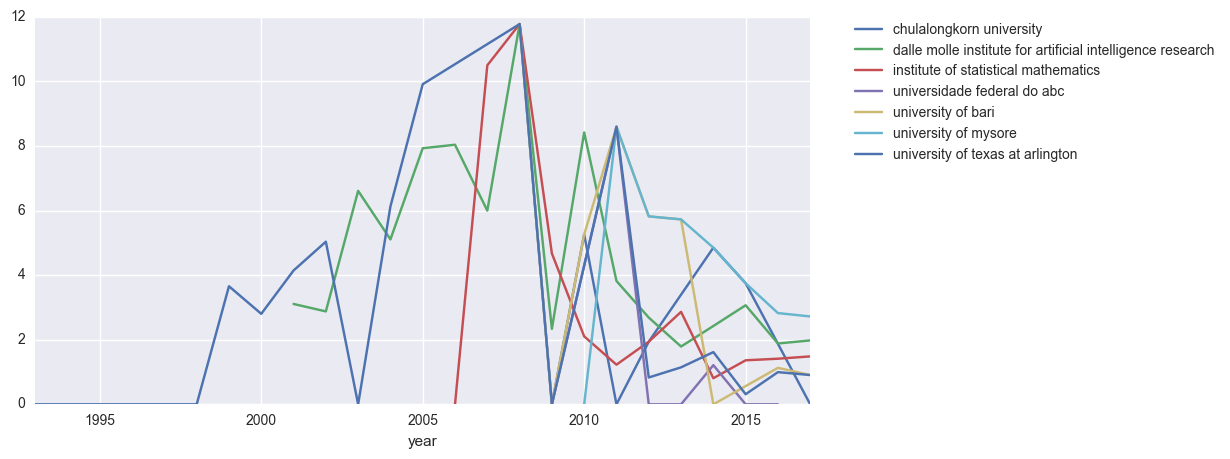

In [7]:
condition = _df.institute.apply(lambda x : x in insts)
fig,ax = plt.subplots(figsize=(10,5))
for inst,grouped in _df.loc[condition].groupby("institute"):
    ax = grouped.plot.line("year","rca",label=inst,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

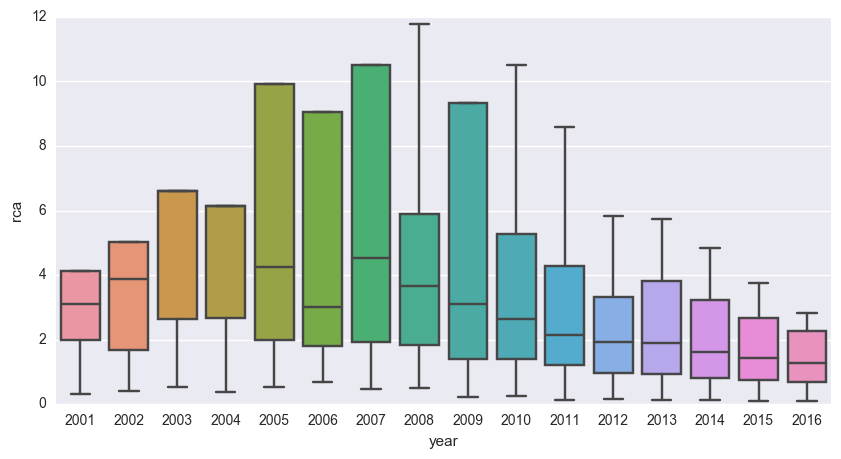

In [8]:
fig,ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=_df.loc[(_df.year > 2000) & (_df.year < 2017) & (_df.rca > 0.1)],x="year",y="rca",ax=ax)

2000 2.37145748988 46
2001 3.82564102564 40
2002 4.61646586345 47
2003 6.05943627451 35
2004 5.75774599932 42
2005 9.39130434783 53
2006 8.34853641933 60
2007 10.0292173252 64
2008 11.2635314996 74
2009 9.11656741985 81
2010 10.2460751089 89
2011 8.44982898837 95
2012 4.64272375617 97
2013 5.46716432799 100
2014 4.67161504991 98
2015 3.03871562905 99
2016 2.00653683463 100


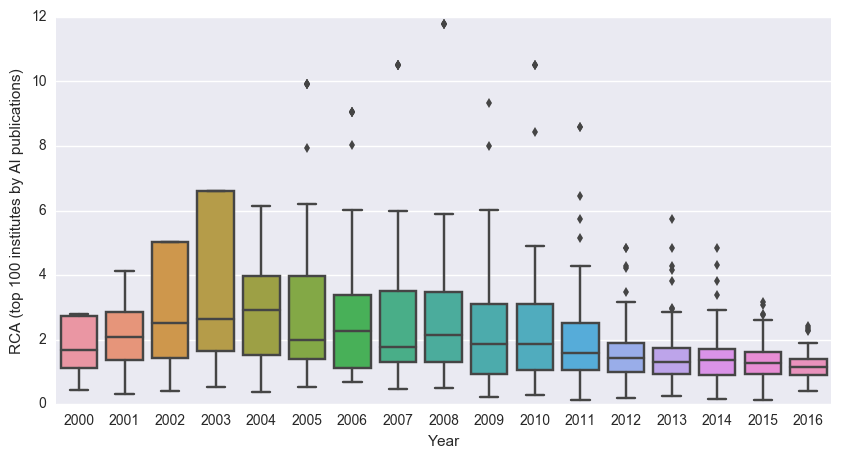

In [9]:
condition = (_df.year >= 2000) & (_df.year < 2017) & (_df.rca > 0)
lens = {}
for inst,grouped in _df.loc[condition].groupby("institute"):
    lens[inst] = len(grouped)
#indexes = _df.loc[condition].sort_values(by="rca",ascending=False).index
most_common = Counter(lens).most_common()[0:100]
most_common = [inst for inst,_ in most_common]

condition = condition & (_df.institute.apply(lambda x : x in most_common))


fig,ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=_df.loc[condition],x="year",y="rca",ax=ax)
ax.set_ylabel("RCA (top 100 institutes by AI publications)")
ax.set_xlabel("Year")

for year,grouped in _df.loc[condition].groupby("year"):
    print(year,max(grouped.rca)-min(grouped.rca),len(grouped))

//anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


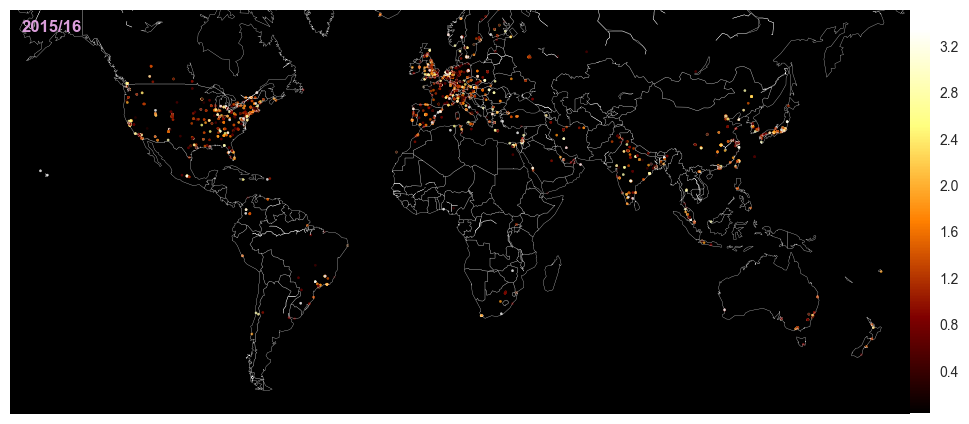

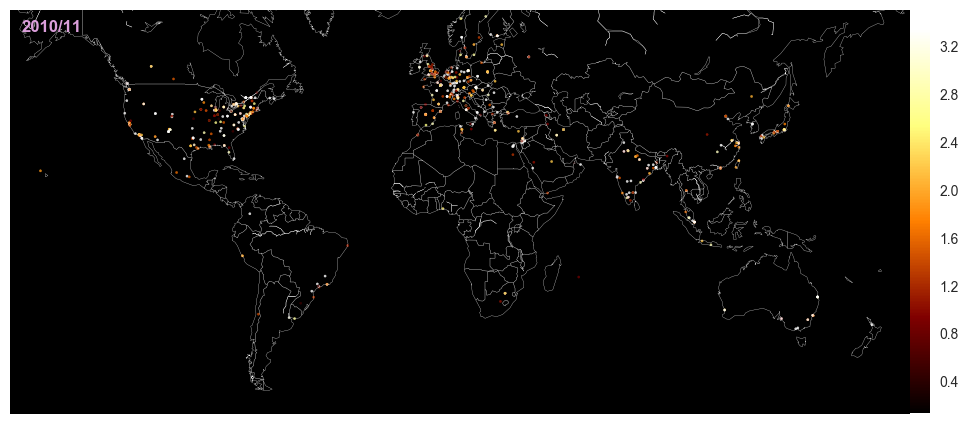

In [29]:
'''Function to plot lat lon coordinates on a map'''
def make_map(df,ax=None,alpha=0.8,s=2.5,embolden=None,text="",
             norm_var=None,cmap=cm.cool,rca_type="rca",**kwargs):
    # Convert lat lon to lists
    lats = list(df.lat)
    lons = list(df.lon)
    # Hack to brighten up markers: plot the marker <embolden> times
    if embolden:
        lats = lats*embolden
        lons = lons*embolden
    # If an axis hasn't been passed, create one
    if ax == None:
        fig = plt.figure(figsize=(10,5))

        ax_cb = fig.add_axes([0.94, 0.097, 0.03, 0.77])
        ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])        
        #fig,ax = plt.subplots(figsize=(10,5))
    # Make the basemap
    m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=65,
                llcrnrlon=-170,urcrnrlon=190,lat_ts=2,resolution='c',)
    m.drawcoastlines(linewidth=0.2,color="white")
    m.drawcountries(linewidth=0.25,color="white")
    m.drawmapboundary(fill_color='black',linewidth=0)
    # Convert the coordiates to this projection
    lons,lats = m(lons,lats)
    # rca color
    df[rca_type].loc[df[rca_type] > norm_var] = norm_var
    norm = mpl.colors.Normalize(vmin=df[rca_type].min(), vmax=norm_var)
    rca = df[rca_type]/norm_var
    

    # Scatter the data
    m.scatter(x=lons,y=lats,ax=ax,
              latlon=False,alpha=alpha,s=s,
              color=cmap(rca),**kwargs)
    
    
    cb = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap,norm=norm,orientation='vertical')
    
    # Top title
    ax.text(5e5, 17e6, text, color="plum", fontsize=12, weight="bold")

    
#     # Summary of data
#     ax.text(5e5, 2.5e6, "Total papers on topic: "+str(condition.sum()), color="white")
#     ax.text(5e5, 1.5e6, "Expected: "+str(int(expected))+" ("+sign+str(int(pc_diff))+"%)", color="white")

#     # 'Legend'
#     ax.text(1.6e7, 3e6, "Institutes involved in the highly cited paper", color="white")
#     ax.text(1.6e7, 2e6, "Institutes with new papers on topic", color="white")
#     ax.scatter([1.55e7]*100,[3.2e6]*100,color="lime",marker=(5,2))
#     ax.scatter([1.55e7]*100,[2.2e6]*100,color="orange",marker="+")
#     ax.add_patch(patches.Rectangle((1.5e7,1.1e6),1.5e7,3.1e6,
#                                    fill=False,edgecolor="white"))

    fig.savefig(text.replace("/","_")+".png")
    
    return ax

condition = (_df.year >= 2000) & (_df.year < 2017) & (_df.rca > 0)
norm_var = np.percentile(_df.rca,92)
cmap = cm.afmhot

ax_16 = make_map(_df.loc[condition & (_df.year >= 2015)],text="2015/16",norm_var=norm_var,cmap=cmap)
ax_11 = make_map(_df.loc[condition & (_df.year < 2012) & (_df.year >= 2010)],text="2010/11",norm_var=norm_var,cmap=cmap)

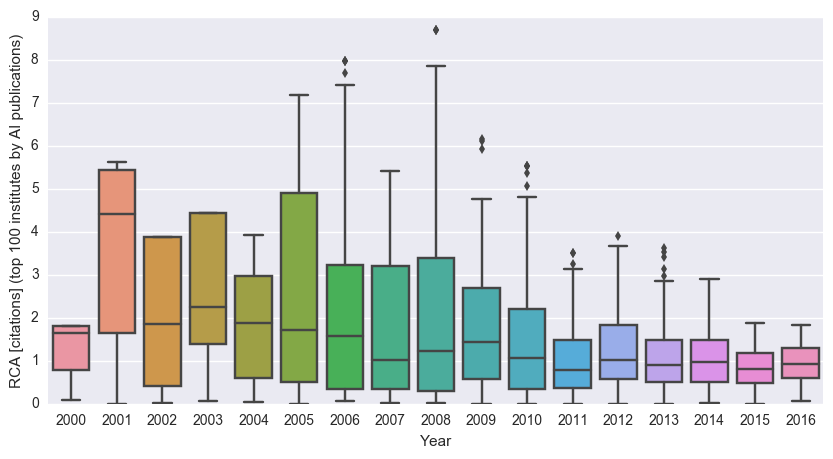

In [11]:
condition = (_df.year >= 2000) & (_df.year < 2017) & (_df.rca_cites > 0)
lens = {}
for inst,grouped in _df.loc[condition].groupby("institute"):
    lens[inst] = len(grouped)
#indexes = _df.loc[condition].sort_values(by="rca",ascending=False).index
most_common = Counter(lens).most_common()[0:100]
most_common = [inst for inst,_ in most_common]

condition = condition & (_df.institute.apply(lambda x : x in most_common))


fig,ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=_df.loc[condition],x="year",y="rca_cites",ax=ax)
ax.set_ylabel("RCA [citations] (top 100 institutes by AI publications)")
ax.set_xlabel("Year")


//anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


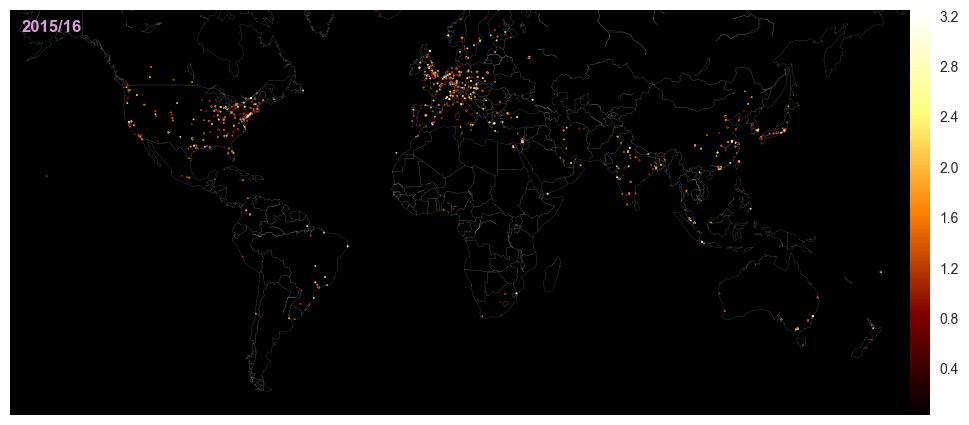

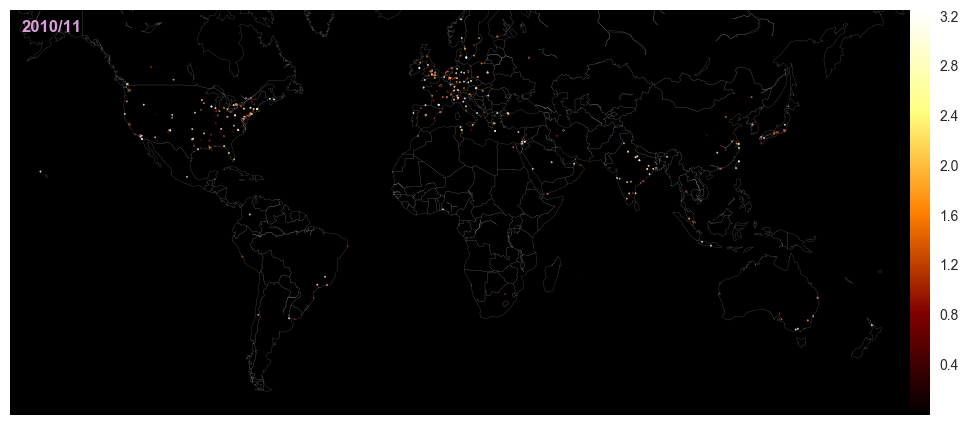

In [12]:
condition = (_df.year >= 2000) & (_df.year < 2017) & (_df.rca_cites > 0)
norm_var = np.percentile(_df.rca_cites,95)
cmap = cm.afmhot

make_map(_df.loc[condition & (_df.year >= 2015)],text="2015/16",norm_var=norm_var,cmap=cmap)
make_map(_df.loc[condition & (_df.year < 2012) & (_df.year >= 2010)],text="2010/11",
         norm_var=norm_var,cmap=cmap,rca_type="rca_cites")

In [13]:
((_df.year >= 2010) & (_df.year < 2012)).sum()

3270

In [14]:
_df.columns

Index(['institute', 'lat', 'lon', 'rca', 'rca_cites', 'year'], dtype='object')

In [15]:
(4950-3270)/3270

0.5137614678899083